[View in Colaboratory](https://colab.research.google.com/github/aksh98/FintechProject/blob/master/NowCastingData_Regression.ipynb)

In [0]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

In [0]:
!pip install -U -q PyDrive


In [0]:
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
creds = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)




In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving GoogleTrendsData.csv to GoogleTrendsData.csv
User uploaded file "GoogleTrendsData.csv" with length 4934 bytes


In [7]:
!ls
!cd sample_data/

adc.json  datalab  GoogleTrendsData.csv  sample_data


In [12]:
%cd ..
!ls

/content
adc.json  datalab  GoogleTrendsData.csv  sample_data


In [54]:
datafile = pd.read_csv('GoogleTrendsData.csv')
datafile.shape

(176, 8)

In [55]:
# datafile.shape[0]
datafile.tail()

,Month,Employment,Unemployment,Productivity,GDP,Stock market,jobs,UMEX
171,2018-04,74,18,1,4,13,68,127.0
172,2018-05,71,16,1,4,9,68,134.0
173,2018-06,71,17,1,3,9,71,132.0
174,2018-07,71,18,1,5,9,71,NaN
175,2018-08,85,16,1,5,11,81,NaN


In [0]:
# print(datafile['UMEX'].max())
# print(datafile['UMEX'].min())

datafile.drop(datafile.tail(2).index,inplace=True)

In [57]:
datafile.tail()

,Month,Employment,Unemployment,Productivity,GDP,Stock market,jobs,UMEX
169,2018-02,72,20,1,5,27,63,136.0
170,2018-03,71,17,1,4,15,64,134.0
171,2018-04,74,18,1,4,13,68,127.0
172,2018-05,71,16,1,4,9,68,134.0
173,2018-06,71,17,1,3,9,71,132.0


In [0]:
Y = datafile['UMEX']
X = datafile[['Employment','Unemployment','Productivity','GDP','jobs']]

In [102]:
X.head()
print(X.shape)

(174, 5)


In [103]:
Y.tail()
# Y.shape 

169    136.0
170    134.0
171    127.0
172    134.0
173    132.0
Name: UMEX, dtype: float64

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)

[-2.41468866 -0.84330721 45.99575034 -0.87576425  1.85262594]
143.48562494936664
tsne shape -  (174, 2)


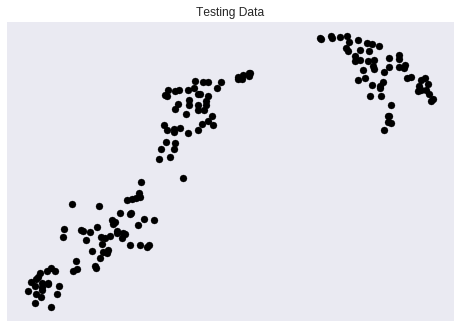

124.0  -> 137.47
112.0  -> 103.67
98.0  -> 83.04
95.0  -> 110.81
73.0  -> 109.12
128.0  -> 134.46
96.0  -> 112.83
95.0  -> 39.74
111.0  -> 127.62
96.0  -> 104.36
144.0  -> 103.54
84.0  -> 104.07
126.0  -> 114.04
112.0  -> 117.86
122.0  -> 119.94
69.0  -> 72.39
84.0  -> 67.42
83.0  -> 28.79
131.0  -> 112.78
98.0  -> 103.08
7.0  -> 55.83
15.0  -> 70.67
92.0  -> 91.73
95.0  -> 116.20
128.0  -> 82.66
55.0  -> 161.85
98.0  -> 98.02
44.0  -> 70.08
129.0  -> 128.71
111.0  -> 118.04
109.0  -> 125.48
84.0  -> 81.04
125.0  -> 111.80
107.0  -> 96.69
109.0  -> 100.61


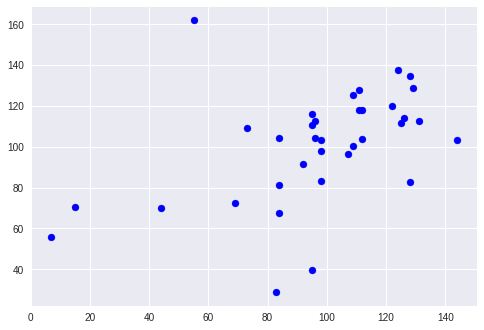

In [105]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

reg = LinearRegression()
reg.fit(X_train,Y_train)
print(reg.coef_)
print(reg.intercept_)

tsne = TSNE(n_components=2).fit_transform(X)
print("tsne shape - ",tsne.shape)

plt.scatter(tsne[:,0],tsne[:,1],color = 'black')
plt.title('Testing Data')
plt.xticks(())
plt.yticks(())
test = np.asarray(Y_test)
# plt.plot(test,reg.predict(X_test),color = 'red',linewidth=3)
plt.show()

arr = reg.predict(X_test)
for i in range(0,len(Y_test)):
  print(test[i]," -> %.2f"%arr[i])

plt.scatter(test,arr,color='blue')
plt.show()

[-1.47022851 -1.00481351  0.65069418  0.12156287  1.00973809]
174.09143938024144
tsne shape -  (174, 2)


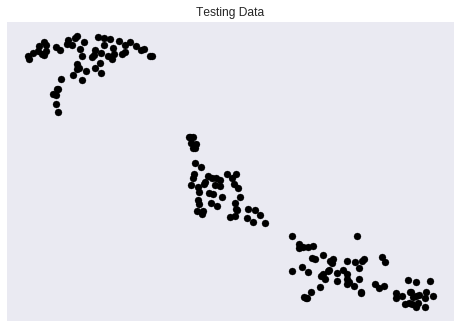

124.0  -> 127.14
112.0  -> 97.25
98.0  -> 98.24
95.0  -> 89.18
73.0  -> 87.79
128.0  -> 126.34
96.0  -> 89.81
95.0  -> 44.84
111.0  -> 122.13
96.0  -> 83.23
144.0  -> 103.47
84.0  -> 96.20
126.0  -> 104.64
112.0  -> 119.00
122.0  -> 117.39
69.0  -> 91.56
84.0  -> 73.81
83.0  -> 43.50
131.0  -> 115.02
98.0  -> 97.29
7.0  -> 59.97
15.0  -> 85.60
92.0  -> 89.40
95.0  -> 92.58
128.0  -> 67.79
55.0  -> 126.60
98.0  -> 80.95
44.0  -> 86.26
129.0  -> 124.81
111.0  -> 113.21
109.0  -> 121.21
84.0  -> 97.44
125.0  -> 112.63
107.0  -> 78.48
109.0  -> 98.37


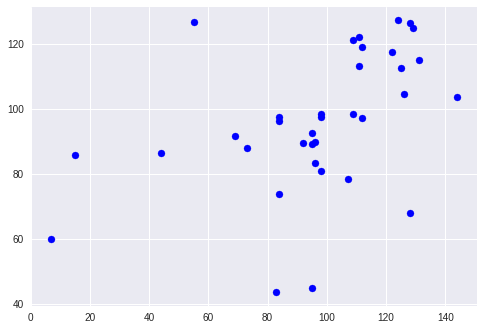

In [109]:
regr = linear_model.BayesianRidge()
regr.fit(X_train,Y_train)
print(regr.coef_)
print(regr.intercept_)

tsne = TSNE(n_components=2).fit_transform(X)
print("tsne shape - ",tsne.shape)

plt.scatter(tsne[:,0],tsne[:,1],color = 'black')
plt.title('Testing Data')
plt.xticks(())
plt.yticks(())
# plt.plot(Y_test,reg.predict(X_test),color = 'red',linewidth=3)
plt.show()

test = np.asarray(Y_test)
arr = regr.predict(X_test)
for i in range(0,len(Y_test)):
  print(test[i]," -> %.2f"%arr[i])
  
plt.scatter(test,arr,color='blue')
plt.show()